In [ ]:
%matplotlib inline


# Audio Classification


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Check if CUDA GPU is available


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing the Dataset

- We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people.
- The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset.

- In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

- The actual loading and formatting steps happen when a data point is
being accessed, and **torchaudio takes care of converting the audio files
to tensors**.

- If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used.

 - It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:27<00:00, 88.7MB/s]


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


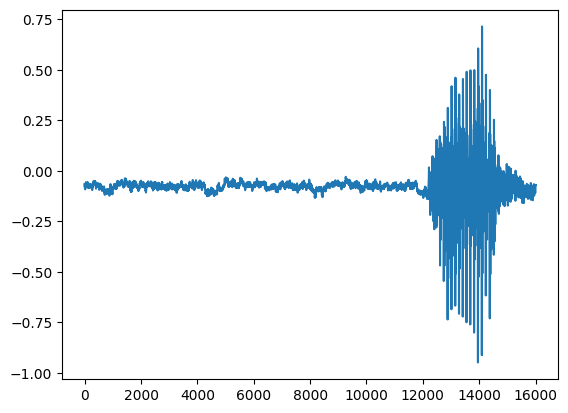

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

The last file




In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Network

We will use a convolutional neural network to process
the raw audio data.



In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# Train

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

# Epoch-Wise Model Train and Test

In [ ]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/2 [00:08<1:43:30, 3109.57s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.846670


  3%|▎         | 0.05599999999999999/2 [00:12<02:48, 86.86s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.126031


  6%|▌         | 0.11199999999999995/2 [00:17<02:27, 77.86s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.617078


  8%|▊         | 0.16266666666666676/2 [00:21<02:35, 84.37s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.288894


 11%|█         | 0.21600000000000033/2 [00:26<02:21, 79.33s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.064368


 13%|█▎        | 0.2693333333333337/2 [00:30<02:24, 83.43s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.943831


 16%|█▌        | 0.3226666666666667/2 [00:34<02:16, 81.59s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.804155


 19%|█▉        | 0.3759999999999997/2 [00:39<02:21, 86.84s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.823771


 21%|██▏       | 0.42933333333333273/2 [00:43<02:04, 79.17s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.617134


 24%|██▍       | 0.4853333333333324/2 [00:48<02:00, 79.41s/it] 

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.634562


 27%|██▋       | 0.5359999999999995/2 [00:52<02:04, 85.02s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.520170


 29%|██▉       | 0.5893333333333336/2 [00:56<01:57, 82.95s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.354585


 32%|███▏      | 0.6426666666666677/2 [01:01<01:49, 80.53s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.232453


 35%|███▍      | 0.6960000000000018/2 [01:05<01:44, 80.31s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.299067


 37%|███▋      | 0.749333333333336/2 [01:10<01:59, 95.38s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.148049


 40%|████      | 0.8026666666666701/2 [01:14<01:51, 93.26s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.181426


 43%|████▎     | 0.8560000000000042/2 [01:19<01:41, 88.41s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.004566


 50%|█████     | 1.0053333333333394/2 [01:33<01:42, 103.42s/it]


Test Epoch: 1	Accuracy: 7088/11005 (64%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.022605


 53%|█████▎    | 1.0586666666666713/2 [01:34<00:26, 27.90s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.885009


 56%|█████▌    | 1.1120000000000032/2 [01:36<00:24, 27.03s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.107488


 58%|█████▊    | 1.165333333333335/2 [01:37<00:25, 30.52s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.867265


 61%|██████    | 1.218666666666667/2 [01:39<00:26, 34.49s/it] 

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.086638


 64%|██████▎   | 1.271999999999999/2 [01:41<00:20, 27.59s/it] 

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.932712


 66%|██████▋   | 1.3253333333333308/2 [01:42<00:17, 26.60s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.073056


 69%|██████▉   | 1.3786666666666627/2 [01:43<00:16, 26.92s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.978759


 72%|███████▏  | 1.4319999999999946/2 [01:45<00:15, 27.06s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 1.128037


 74%|███████▍  | 1.4853333333333265/2 [01:46<00:14, 27.59s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.985885


 77%|███████▋  | 1.5386666666666584/2 [01:48<00:12, 26.66s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.039224


 80%|███████▉  | 1.5919999999999903/2 [01:49<00:11, 27.54s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.806004


 82%|████████▏ | 1.6453333333333222/2 [01:51<00:11, 32.89s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.982974


 85%|████████▍ | 1.6986666666666541/2 [01:53<00:08, 27.76s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 1.058771


 88%|████████▊ | 1.751999999999986/2 [01:54<00:06, 26.75s/it] 

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.995234


 90%|█████████ | 1.805333333333318/2 [01:55<00:05, 26.91s/it] 

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.834296


 93%|█████████▎| 1.8586666666666498/2 [01:57<00:03, 27.83s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.854824


100%|█████████▉| 1.9999999999999793/2 [02:02<00:00, 61.37s/it]


Test Epoch: 2	Accuracy: 6937/11005 (63%)



Text(0.5, 1.0, 'training loss over iterations')

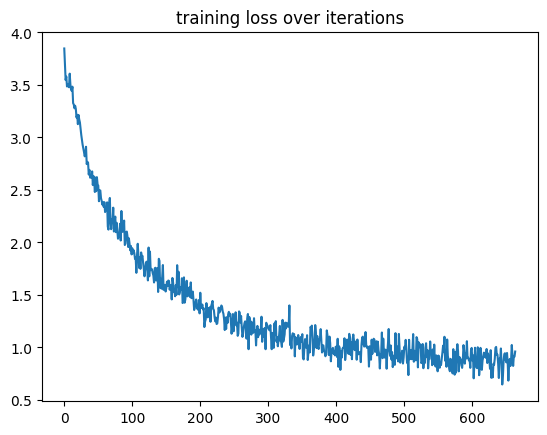

In [ ]:
plt.plot(losses)
plt.title("training loss over iterations")

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: learn.


# Record your own audio and classify




In [ ]:
!pip3 install pydub

In [ ]:
def record(seconds=1):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 1 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: yes.


In [ ]:
model

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)

In [ ]:
waveform_new,sample_rate_upload = torchaudio.load('CantinaBand3.wav')

In [ ]:
waveform_new.shape,sample_rate_upload, transform(waveform_new.cuda()).shape

In [ ]:
ipd.Audio(transform(waveform_new.cuda()).cpu().numpy(), rate=8000)

# Exercise

- Train the above classifier for 10 epochs and report the test accuracy.
- Change all the convolutional layers of the above classifier to fully connected layers and train it for 10 epochs and report the test accuracy.
- Train a classifier for only the classes "yes" and "no" for 20 epochs. Make changes to the dataset and network accordingly. Report the test accuracy.

## Accuracy for 10 epochs

In [ ]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.005333333333333333/10 [00:00<04:48, 28.85s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.955570


  1%|          | 0.05866666666666665/10 [00:01<04:26, 26.76s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.622260


  1%|          | 0.11199999999999995/10 [00:03<04:31, 27.42s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.799015


  2%|▏         | 0.16533333333333344/10 [00:04<04:26, 27.10s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.844271


  2%|▏         | 0.218666666666667/10 [00:06<04:25, 27.16s/it]  

Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.827910


  3%|▎         | 0.27200000000000035/10 [00:07<05:21, 33.00s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.673704


  3%|▎         | 0.32533333333333336/10 [00:09<04:39, 28.87s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.854664


  4%|▍         | 0.3786666666666664/10 [00:10<04:14, 26.43s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.786981


  4%|▍         | 0.4319999999999994/10 [00:12<04:08, 26.01s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.828619


  5%|▍         | 0.4853333333333324/10 [00:13<04:17, 27.01s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.914516


  5%|▌         | 0.5386666666666662/10 [00:15<04:15, 27.05s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.761431


  6%|▌         | 0.5920000000000003/10 [00:16<04:11, 26.78s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.716980


  6%|▋         | 0.6453333333333344/10 [00:17<04:14, 27.17s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.785180


  7%|▋         | 0.6986666666666685/10 [00:19<04:59, 32.23s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.887428


  8%|▊         | 0.7520000000000027/10 [00:21<05:20, 34.63s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.704001


  8%|▊         | 0.8053333333333368/10 [00:22<04:10, 27.28s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.720550


  9%|▊         | 0.8586666666666709/10 [00:24<04:06, 26.96s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.746032


 10%|█         | 1.0026666666666728/10 [00:27<03:49, 25.54s/it]


Test Epoch: 1	Accuracy: 8038/11005 (73%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.703550


 11%|█         | 1.061333333333338/10 [00:29<03:59, 26.76s/it] 

Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.752495


 11%|█         | 1.1146666666666698/10 [00:30<03:58, 26.84s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.788930


 12%|█▏        | 1.1680000000000017/10 [00:32<05:36, 38.05s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.693384


 12%|█▏        | 1.2213333333333336/10 [00:34<04:10, 28.50s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.856211


 13%|█▎        | 1.2746666666666655/10 [00:35<03:55, 26.95s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 0.959981


 13%|█▎        | 1.3279999999999974/10 [00:37<03:50, 26.55s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.713059


 14%|█▍        | 1.3813333333333293/10 [00:38<03:51, 26.83s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.795080


 14%|█▍        | 1.4346666666666612/10 [00:40<03:50, 26.94s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.627152


 15%|█▍        | 1.487999999999993/10 [00:41<03:48, 26.87s/it]

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.580182


 15%|█▌        | 1.541333333333325/10 [00:43<03:50, 27.21s/it] 

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.737268


 16%|█▌        | 1.594666666666657/10 [00:44<04:35, 32.73s/it] 

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.742741


 16%|█▋        | 1.6479999999999888/10 [00:46<04:18, 30.94s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.581814


 17%|█▋        | 1.7013333333333207/10 [00:47<03:47, 27.36s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.849694


 18%|█▊        | 1.7546666666666526/10 [00:49<03:40, 26.70s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.810919


 18%|█▊        | 1.8079999999999845/10 [00:50<03:36, 26.42s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.747896


 19%|█▊        | 1.8613333333333164/10 [00:52<03:37, 26.76s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.726384


 20%|██        | 2.0053333333333128/10 [00:55<03:23, 25.49s/it]


Test Epoch: 2	Accuracy: 8036/11005 (73%)

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.791911


 21%|██        | 2.058666666666649/10 [00:57<04:24, 33.36s/it] 

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.768891


 21%|██        | 2.1119999999999854/10 [00:59<03:50, 29.20s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.691689


 22%|██▏       | 2.159999999999988/10 [01:00<03:56, 30.15s/it] 

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.568271


 22%|██▏       | 2.218666666666658/10 [01:02<03:51, 29.74s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.539484


 23%|██▎       | 2.2719999999999945/10 [01:04<03:33, 27.58s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.720380


 23%|██▎       | 2.325333333333331/10 [01:05<03:35, 28.05s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.675969


 24%|██▍       | 2.378666666666667/10 [01:07<03:25, 26.95s/it] 

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.709632


 24%|██▍       | 2.4320000000000035/10 [01:08<03:31, 27.93s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.788297


 25%|██▍       | 2.48533333333334/10 [01:10<04:07, 32.95s/it] 

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.605362


 25%|██▌       | 2.538666666666676/10 [01:11<03:30, 28.24s/it] 

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.675099


 26%|██▌       | 2.5920000000000125/10 [01:13<03:18, 26.82s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.574562


 26%|██▋       | 2.645333333333349/10 [01:14<03:20, 27.31s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.736121


 27%|██▋       | 2.698666666666685/10 [01:16<03:14, 26.64s/it] 

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.667357


 28%|██▊       | 2.7520000000000215/10 [01:17<03:10, 26.34s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.578152


 28%|██▊       | 2.805333333333358/10 [01:19<03:12, 26.80s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.687767


 29%|██▊       | 2.8586666666666942/10 [01:20<03:10, 26.70s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.691955


 30%|███       | 3.0026666666667023/10 [01:24<03:01, 26.01s/it]


Test Epoch: 3	Accuracy: 8307/11005 (75%)

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.606831


 31%|███       | 3.0613333333333723/10 [01:26<03:10, 27.52s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.841963


 31%|███       | 3.1146666666667087/10 [01:27<03:04, 26.75s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.534517


 32%|███▏      | 3.168000000000045/10 [01:29<03:17, 28.90s/it] 

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.620974


 32%|███▏      | 3.2213333333333813/10 [01:30<03:00, 26.59s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.726379


 33%|███▎      | 3.2746666666667177/10 [01:32<02:59, 26.76s/it]

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.683808


 33%|███▎      | 3.328000000000054/10 [01:33<02:59, 26.91s/it] 

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.590250


 34%|███▍      | 3.3813333333333904/10 [01:35<03:46, 34.16s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.698858


 34%|███▍      | 3.4346666666667267/10 [01:37<03:03, 27.88s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.630202


 35%|███▍      | 3.488000000000063/10 [01:38<02:53, 26.66s/it] 

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.736000


 35%|███▌      | 3.5413333333333994/10 [01:39<02:50, 26.45s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.621956


 36%|███▌      | 3.5946666666667357/10 [01:41<02:52, 26.88s/it]

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.671938


 36%|███▋      | 3.648000000000072/10 [01:42<02:49, 26.66s/it] 

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.630778


 37%|███▋      | 3.7013333333334084/10 [01:44<02:48, 26.75s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.552844


 38%|███▊      | 3.752000000000078/10 [01:46<04:43, 45.40s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.547871


 38%|███▊      | 3.808000000000081/10 [01:48<03:40, 35.60s/it] 

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.690669


 39%|███▊      | 3.8613333333334174/10 [01:49<02:47, 27.24s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.620149


 40%|████      | 4.0000000000000915/10 [01:56<05:00, 50.02s/it]


Test Epoch: 4	Accuracy: 8635/11005 (78%)



 40%|████      | 4.005333333333424/10 [01:57<05:45, 57.59s/it]

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.581403


 41%|████      | 4.058666666666752/10 [02:00<07:47, 78.72s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.612041


 41%|████      | 4.1146666666667455/10 [02:02<03:13, 32.81s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.545195


 42%|████▏     | 4.168000000000073/10 [02:04<02:36, 26.87s/it]

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.523318


 42%|████▏     | 4.2213333333334/10 [02:05<02:33, 26.55s/it]  

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.944783


 43%|████▎     | 4.274666666666728/10 [02:07<02:35, 27.11s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.630850


 43%|████▎     | 4.328000000000055/10 [02:08<02:31, 26.74s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.593528


 44%|████▍     | 4.381333333333383/10 [02:10<02:29, 26.53s/it]

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.621614


 44%|████▍     | 4.43466666666671/10 [02:11<02:41, 29.06s/it]  

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.685611


 45%|████▍     | 4.488000000000038/10 [02:13<03:07, 34.05s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.595755


 45%|████▌     | 4.541333333333365/10 [02:14<02:33, 28.14s/it] 

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.543958


 46%|████▌     | 4.594666666666693/10 [02:16<02:24, 26.78s/it]

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.760442


 46%|████▋     | 4.64800000000002/10 [02:17<02:23, 26.88s/it] 

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.633263


 47%|████▋     | 4.701333333333348/10 [02:19<02:21, 26.79s/it]

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.756842


 48%|████▊     | 4.754666666666675/10 [02:20<02:24, 27.58s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.650165


 48%|████▊     | 4.8080000000000025/10 [02:22<02:21, 27.18s/it]

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.577165


 49%|████▊     | 4.86133333333333/10 [02:23<02:20, 27.30s/it] 

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.684558


 50%|█████     | 5.005333333333314/10 [02:28<02:21, 28.34s/it]


Test Epoch: 5	Accuracy: 8662/11005 (79%)

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.625104


 51%|█████     | 5.0586666666666416/10 [02:29<02:13, 27.01s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.519019


 51%|█████     | 5.111999999999969/10 [02:31<02:09, 26.54s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.511004


 52%|█████▏    | 5.167999999999963/10 [02:33<02:58, 36.86s/it]

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.555203


 52%|█████▏    | 5.22133333333329/10 [02:35<02:22, 29.75s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.619293


 53%|█████▎    | 5.274666666666618/10 [02:36<02:06, 26.88s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.517402


 53%|█████▎    | 5.327999999999945/10 [02:38<02:38, 33.97s/it] 

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.601124


 54%|█████▍    | 5.378666666666606/10 [02:40<03:17, 42.73s/it]

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.569092


 54%|█████▍    | 5.4346666666666/10 [02:42<02:57, 38.89s/it]  

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.755543


 55%|█████▍    | 5.485333333333261/10 [02:44<03:05, 41.06s/it]

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.637270


 55%|█████▌    | 5.535999999999922/10 [02:45<02:21, 31.75s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.602478


 56%|█████▌    | 5.591999999999916/10 [02:49<04:05, 55.65s/it]

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.540863


 56%|█████▋    | 5.642666666666577/10 [02:52<02:39, 36.56s/it] 

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.485541


 57%|█████▋    | 5.695999999999905/10 [02:54<02:33, 35.65s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.687904


 57%|█████▋    | 5.749333333333232/10 [02:56<02:25, 34.16s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.530035


 58%|█████▊    | 5.80266666666656/10 [02:58<02:21, 33.67s/it] 

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.588856


 59%|█████▊    | 5.855999999999887/10 [03:00<02:31, 36.49s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.572306


 60%|█████▉    | 5.999999999999871/10 [03:06<02:30, 37.59s/it] 


Test Epoch: 6	Accuracy: 8136/11005 (74%)

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.518457


 61%|██████    | 6.058666666666531/10 [03:09<02:41, 41.04s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.678113


 61%|██████    | 6.114666666666525/10 [03:11<02:03, 31.68s/it] 

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.658854


 62%|██████▏   | 6.165333333333186/10 [03:13<02:31, 39.49s/it]

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.472964


 62%|██████▏   | 6.218666666666514/10 [03:15<01:52, 29.69s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.542554


 63%|██████▎   | 6.274666666666508/10 [03:17<02:36, 41.97s/it]

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.700428


 63%|██████▎   | 6.327999999999835/10 [03:19<02:17, 37.38s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.497806


 64%|██████▍   | 6.378666666666496/10 [03:21<02:10, 35.92s/it]

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.516722


 64%|██████▍   | 6.43466666666649/10 [03:23<01:59, 33.55s/it] 

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.615677


 65%|██████▍   | 6.482666666666485/10 [03:25<02:41, 46.02s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.398665


 65%|██████▌   | 6.535999999999812/10 [03:27<02:33, 44.32s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.587281


 66%|██████▌   | 6.591999999999806/10 [03:29<01:57, 34.61s/it]

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.619632


 66%|██████▋   | 6.6453333333331335/10 [03:30<01:34, 28.22s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.591855


 67%|██████▋   | 6.698666666666461/10 [03:32<02:00, 36.41s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.680561


 68%|██████▊   | 6.751999999999788/10 [03:34<01:29, 27.48s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.581518


 68%|██████▊   | 6.805333333333116/10 [03:35<01:26, 27.15s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.530189


 69%|██████▊   | 6.858666666666443/10 [03:37<02:14, 42.77s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.573712


 70%|███████   | 7.0026666666664275/10 [03:41<01:37, 32.53s/it]


Test Epoch: 7	Accuracy: 8597/11005 (78%)

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.581926


 71%|███████   | 7.061333333333088/10 [03:43<01:22, 28.11s/it]

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.458323


 71%|███████   | 7.114666666666415/10 [03:44<01:18, 27.07s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.513087


 72%|███████▏  | 7.167999999999743/10 [03:46<01:16, 27.06s/it]

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.639268


 72%|███████▏  | 7.215999999999737/10 [03:47<01:28, 31.87s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.511906


 73%|███████▎  | 7.2746666666663975/10 [03:49<01:25, 31.32s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.616268


 73%|███████▎  | 7.327999999999725/10 [03:51<01:30, 33.80s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.627850


 74%|███████▍  | 7.378666666666386/10 [03:53<02:25, 55.46s/it]

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.499172


 74%|███████▍  | 7.43466666666638/10 [03:55<01:14, 28.99s/it] 

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.499270


 75%|███████▍  | 7.487999999999707/10 [03:57<01:06, 26.56s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.584161


 75%|███████▌  | 7.541333333333035/10 [03:58<01:06, 27.19s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.545033


 76%|███████▌  | 7.594666666666362/10 [03:59<01:02, 26.17s/it] 

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.550548


 76%|███████▋  | 7.64799999999969/10 [04:01<01:03, 27.01s/it] 

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.705202


 77%|███████▋  | 7.701333333333017/10 [04:02<01:01, 26.81s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.672283


 78%|███████▊  | 7.754666666666345/10 [04:04<01:00, 26.74s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.522093


 78%|███████▊  | 7.807999999999672/10 [04:06<01:28, 40.56s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.620889


 79%|███████▊  | 7.8613333333329996/10 [04:08<01:24, 39.37s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.700562


 80%|████████  | 8.002666666666318/10 [04:12<01:03, 31.83s/it]


Test Epoch: 8	Accuracy: 8054/11005 (73%)

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.496843


 81%|████████  | 8.061333333332978/10 [04:14<01:04, 33.36s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.614045


 81%|████████  | 8.109333333332973/10 [04:16<01:06, 35.38s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.535003


 82%|████████▏ | 8.1626666666663/10 [04:18<01:07, 36.93s/it]  

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.456556


 82%|████████▏ | 8.218666666666294/10 [04:20<00:57, 32.12s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.542688


 83%|████████▎ | 8.271999999999622/10 [04:22<01:04, 37.40s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.536662


 83%|████████▎ | 8.32533333333295/10 [04:24<00:46, 27.55s/it] 

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.597602


 84%|████████▍ | 8.378666666666277/10 [04:25<00:43, 27.09s/it]

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.561825


 84%|████████▍ | 8.431999999999604/10 [04:26<00:41, 26.64s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.510783


 85%|████████▍ | 8.485333333332932/10 [04:28<00:40, 26.69s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.573963


 85%|████████▌ | 8.53866666666626/10 [04:29<00:39, 26.88s/it] 

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.715119


 86%|████████▌ | 8.591999999999587/10 [04:32<01:13, 51.92s/it]

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.693737


 86%|████████▋ | 8.645333333332914/10 [04:34<00:50, 37.49s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.561010


 87%|████████▋ | 8.698666666666242/10 [04:36<00:40, 31.33s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.532570


 88%|████████▊ | 8.751999999999569/10 [04:37<00:43, 34.68s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.672710


 88%|████████▊ | 8.805333333332896/10 [04:39<00:37, 31.72s/it]

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.546638


 89%|████████▊ | 8.858666666666224/10 [04:42<01:00, 52.76s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.735628


 90%|█████████ | 9.002666666666208/10 [04:48<00:27, 27.50s/it]


Test Epoch: 9	Accuracy: 8775/11005 (80%)

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.414693


 91%|█████████ | 9.061333333332868/10 [04:49<00:25, 27.13s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.605361


 91%|█████████ | 9.114666666666196/10 [04:51<00:23, 26.99s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.539694


 92%|█████████▏| 9.167999999999523/10 [04:52<00:22, 27.22s/it]

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.455115


 92%|█████████▏| 9.22133333333285/10 [04:54<00:20, 26.62s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.595176


 93%|█████████▎| 9.274666666666178/10 [04:55<00:19, 26.58s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.550259


 93%|█████████▎| 9.327999999999506/10 [04:57<00:22, 33.54s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.547930


 94%|█████████▍| 9.381333333332833/10 [04:59<00:17, 28.21s/it]

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.433128


 94%|█████████▍| 9.43466666666616/10 [05:00<00:15, 26.72s/it] 

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.561710


 95%|█████████▍| 9.487999999999488/10 [05:01<00:13, 26.86s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.552340


 95%|█████████▌| 9.541333333332815/10 [05:03<00:12, 26.65s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.509975


 96%|█████████▌| 9.594666666666143/10 [05:04<00:10, 26.87s/it]

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.557589


 96%|█████████▋| 9.64799999999947/10 [05:06<00:09, 26.70s/it] 

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.419115


 97%|█████████▋| 9.701333333332798/10 [05:07<00:07, 26.59s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.500733


 98%|█████████▊| 9.754666666666125/10 [05:09<00:08, 34.14s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.531730


 98%|█████████▊| 9.807999999999453/10 [05:11<00:06, 31.82s/it]

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.517989


 99%|█████████▊| 9.86133333333278/10 [05:12<00:03, 26.67s/it] 

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.558971


100%|█████████▉| 9.999999999999432/10 [05:15<00:00, 31.60s/it]


Test Epoch: 10	Accuracy: 8817/11005 (80%)



80% accuracy after 10 epochs

## Changing Convolutional layers to FC layers

In [ ]:
class M5_fc(nn.Module):
    def __init__(self, n_input=8000, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Linear(n_input, 1024)
        self.bn1 = nn.BatchNorm1d(1024)

        self.conv2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)

        self.conv3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.conv4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.fc1 = nn.Linear(256, n_output)



    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)

        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


model_fc = M5_fc(n_input=transformed.shape[1], n_output=len(labels))
model_fc.to(device)
print(model_fc)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5_fc(
  (conv1): Linear(in_features=8000, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Linear(in_features=1024, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Linear(in_features=256, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Linear(in_features=512, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=35, bias=True)
)
Number of parameters: 26915


In [ ]:
optimizer = optim.Adam(model_fc.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


In [ ]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_fc, epoch, log_interval)
        test(model_fc, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/10 [00:00<45:39, 274.00s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.577788


  1%|          | 0.05599999999999999/10 [00:10<27:34, 166.39s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.687379


  1%|          | 0.10933333333333328/10 [00:19<31:52, 193.35s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.571158


  2%|▏         | 0.16266666666666676/10 [00:28<23:38, 144.18s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 3.495690


  2%|▏         | 0.21600000000000033/10 [00:37<25:52, 158.70s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 3.519665


  3%|▎         | 0.2693333333333337/10 [00:46<28:16, 174.35s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 3.495832


  3%|▎         | 0.3226666666666667/10 [00:55<28:36, 177.38s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 3.519336


  4%|▍         | 0.3759999999999997/10 [01:04<24:05, 150.16s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 3.454584


  4%|▍         | 0.42933333333333273/10 [01:14<27:34, 172.90s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 3.481969


  5%|▍         | 0.48266666666666574/10 [01:23<32:00, 201.82s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 3.415716


  5%|▌         | 0.5359999999999995/10 [01:31<26:06, 165.53s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 3.435209


  6%|▌         | 0.5893333333333336/10 [01:41<26:06, 166.46s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 3.434190


  6%|▋         | 0.6426666666666677/10 [01:50<31:58, 205.00s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 3.447920


  7%|▋         | 0.6960000000000018/10 [01:59<24:54, 160.65s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 3.411122


  7%|▋         | 0.749333333333336/10 [02:09<24:04, 156.11s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 3.409003


  8%|▊         | 0.8026666666666701/10 [02:18<26:58, 176.02s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 3.492694


  9%|▊         | 0.8560000000000042/10 [02:27<29:56, 196.43s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 3.407545


 10%|█         | 1.0000000000000062/10 [02:43<14:11, 94.64s/it]


Test Epoch: 1	Accuracy: 770/11005 (7%)



 10%|█         | 1.0026666666666728/10 [02:44<17:31, 116.88s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 3.335927


 11%|█         | 1.0560000000000047/10 [02:53<29:44, 199.49s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 3.397462


 11%|█         | 1.1093333333333366/10 [03:02<22:48, 153.94s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 3.370863


 12%|█▏        | 1.1626666666666685/10 [03:11<24:08, 163.92s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 3.357793


 12%|█▏        | 1.2160000000000004/10 [03:21<31:47, 217.11s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 3.349457


 13%|█▎        | 1.2693333333333323/10 [03:30<24:00, 165.04s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 3.353349


 13%|█▎        | 1.3226666666666642/10 [03:39<22:39, 156.68s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 3.339152


 14%|█▍        | 1.3759999999999961/10 [03:49<25:39, 178.47s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 3.353863


 14%|█▍        | 1.429333333333328/10 [03:58<26:40, 186.73s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 3.396949


 15%|█▍        | 1.48266666666666/10 [04:07<20:29, 144.40s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 3.432331


 15%|█▌        | 1.5359999999999918/10 [04:16<23:04, 163.61s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 3.380185


 16%|█▌        | 1.5893333333333237/10 [04:26<30:32, 217.94s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 3.390043


 16%|█▋        | 1.6426666666666556/10 [04:34<20:05, 144.21s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 3.304982


 17%|█▋        | 1.6959999999999875/10 [04:44<23:00, 166.28s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 3.319846


 17%|█▋        | 1.7493333333333194/10 [04:53<26:04, 189.61s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 3.332430


 18%|█▊        | 1.8026666666666513/10 [05:01<21:57, 160.74s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 3.341363


 19%|█▊        | 1.8559999999999832/10 [05:11<21:25, 157.89s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 3.274276


 20%|█▉        | 1.9999999999999793/10 [05:27<24:55, 186.94s/it]


Test Epoch: 2	Accuracy: 829/11005 (8%)



 20%|██        | 2.002666666666646/10 [05:29<38:28, 288.69s/it] 

Train Epoch: 3 [0/84843 (0%)]	Loss: 3.300632


 21%|██        | 2.0559999999999823/10 [05:40<20:49, 157.26s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 3.238761


 21%|██        | 2.1093333333333186/10 [05:50<20:59, 159.64s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 3.329478


 22%|██▏       | 2.162666666666655/10 [06:00<25:23, 194.34s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 3.337296


 22%|██▏       | 2.2159999999999913/10 [06:08<22:06, 170.40s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 3.350550


 23%|██▎       | 2.2693333333333277/10 [06:19<22:58, 178.34s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 3.275680


 23%|██▎       | 2.322666666666664/10 [06:29<23:31, 183.84s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 3.273367


 24%|██▍       | 2.3760000000000003/10 [06:39<26:07, 205.61s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 3.293337


 24%|██▍       | 2.4293333333333367/10 [06:47<20:24, 161.72s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 3.401542


 25%|██▍       | 2.482666666666673/10 [06:58<21:27, 171.28s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 3.224631


 25%|██▌       | 2.5360000000000094/10 [07:08<20:11, 162.32s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 3.318240


 26%|██▌       | 2.5893333333333457/10 [07:18<27:03, 219.03s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 3.324786


 26%|██▋       | 2.642666666666682/10 [07:27<19:29, 158.95s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 3.351256


 27%|██▋       | 2.6960000000000184/10 [07:36<21:09, 173.82s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 3.396455


 27%|██▋       | 2.7493333333333547/10 [07:46<19:57, 165.12s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 3.333838


 28%|██▊       | 2.802666666666691/10 [07:56<27:37, 230.35s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 3.267695


 29%|██▊       | 2.8560000000000274/10 [08:05<20:51, 175.17s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 3.220510


 30%|███       | 3.0000000000000355/10 [08:22<14:20, 122.95s/it]


Test Epoch: 3	Accuracy: 778/11005 (7%)



 30%|███       | 3.0026666666667023/10 [08:22<16:37, 142.61s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 3.236031


 31%|███       | 3.0560000000000387/10 [08:31<18:30, 159.96s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 3.147041


 31%|███       | 3.109333333333375/10 [08:41<19:04, 166.05s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 3.287129


 32%|███▏      | 3.1626666666667114/10 [08:51<20:50, 182.85s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 3.203955


 32%|███▏      | 3.2160000000000477/10 [09:00<24:03, 212.71s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 3.250459


 33%|███▎      | 3.269333333333384/10 [09:10<18:58, 169.11s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 3.298689


 33%|███▎      | 3.3226666666667204/10 [09:20<19:09, 172.18s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 3.334581


 34%|███▍      | 3.3760000000000567/10 [09:29<20:27, 185.33s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 3.312969


 34%|███▍      | 3.429333333333393/10 [09:38<21:43, 198.41s/it] 

Train Epoch: 4 [40960/84843 (48%)]	Loss: 3.211223


 35%|███▍      | 3.4826666666667294/10 [09:48<17:14, 158.81s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 3.338338


 35%|███▌      | 3.5360000000000658/10 [09:57<18:48, 174.58s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 3.236240


 36%|███▌      | 3.589333333333402/10 [10:07<20:11, 188.91s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 3.212353


 36%|███▋      | 3.6426666666667384/10 [10:16<17:19, 163.53s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 3.418172


 37%|███▋      | 3.696000000000075/10 [10:26<17:46, 169.11s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 3.299973


 37%|███▋      | 3.749333333333411/10 [10:36<16:32, 158.75s/it] 

Train Epoch: 4 [71680/84843 (84%)]	Loss: 3.281399


 38%|███▊      | 3.8026666666667475/10 [10:45<22:22, 216.58s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 3.262418


 39%|███▊      | 3.856000000000084/10 [10:54<16:43, 163.29s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 3.275470


 40%|████      | 4.0000000000000915/10 [11:10<12:13, 122.17s/it]


Test Epoch: 4	Accuracy: 847/11005 (8%)



 40%|████      | 4.002666666666758/10 [11:11<15:50, 158.49s/it] 

Train Epoch: 5 [0/84843 (0%)]	Loss: 3.144480


 41%|████      | 4.056000000000085/10 [11:20<17:00, 171.68s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 3.159208


 41%|████      | 4.109333333333413/10 [11:30<17:03, 173.82s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 3.174396


 42%|████▏     | 4.16266666666674/10 [11:40<15:17, 157.23s/it] 

Train Epoch: 5 [15360/84843 (18%)]	Loss: 3.160096


 42%|████▏     | 4.216000000000068/10 [11:49<19:06, 198.19s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 3.315392


 43%|████▎     | 4.269333333333395/10 [11:58<14:33, 152.34s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 3.268842


 43%|████▎     | 4.322666666666723/10 [12:07<14:31, 153.51s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 3.326529


 44%|████▍     | 4.37600000000005/10 [12:17<17:26, 186.13s/it] 

Train Epoch: 5 [35840/84843 (42%)]	Loss: 3.263283


 44%|████▍     | 4.4293333333333775/10 [12:25<15:40, 168.87s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 3.293631


 45%|████▍     | 4.482666666666705/10 [12:35<16:22, 178.07s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 3.246899


 45%|████▌     | 4.5360000000000325/10 [12:45<15:26, 169.63s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 3.200807


 46%|████▌     | 4.58933333333336/10 [12:54<20:00, 221.84s/it]  

Train Epoch: 5 [56320/84843 (66%)]	Loss: 3.278231


 46%|████▋     | 4.642666666666687/10 [13:03<13:28, 150.98s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 3.263389


 47%|████▋     | 4.696000000000015/10 [13:12<13:33, 153.41s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 3.182887


 47%|████▋     | 4.749333333333342/10 [13:22<16:19, 186.54s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 3.249800


 48%|████▊     | 4.80266666666667/10 [13:30<14:28, 167.14s/it] 

Train Epoch: 5 [76800/84843 (90%)]	Loss: 3.359770


 49%|████▊     | 4.855999999999997/10 [13:40<14:38, 170.73s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 3.276333


 50%|████▉     | 4.999999999999981/10 [13:56<07:17, 87.55s/it]


Test Epoch: 5	Accuracy: 857/11005 (8%)



 50%|█████     | 5.002666666666648/10 [13:56<08:51, 106.26s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 3.187092


 51%|█████     | 5.055999999999975/10 [14:06<12:56, 157.02s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 3.193057


 51%|█████     | 5.109333333333303/10 [14:16<14:37, 179.45s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 3.199756


 52%|█████▏    | 5.16266666666663/10 [14:26<20:00, 248.16s/it] 

Train Epoch: 6 [15360/84843 (18%)]	Loss: 3.268770


 52%|█████▏    | 5.215999999999958/10 [14:36<17:20, 217.40s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 3.187300


 53%|█████▎    | 5.269333333333285/10 [14:47<16:05, 204.14s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 3.288000


 53%|█████▎    | 5.3226666666666125/10 [14:59<15:48, 202.87s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 3.184894


 54%|█████▍    | 5.37599999999994/10 [15:12<17:06, 221.91s/it] 

Train Epoch: 6 [35840/84843 (42%)]	Loss: 3.184032


 54%|█████▍    | 5.429333333333267/10 [15:25<18:09, 238.35s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 3.209881


 55%|█████▍    | 5.482666666666595/10 [15:46<49:36, 658.95s/it] 

Train Epoch: 6 [46080/84843 (54%)]	Loss: 3.142696


 55%|█████▌    | 5.535999999999922/10 [16:04<25:05, 337.22s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 3.200569


 56%|█████▌    | 5.58933333333325/10 [16:24<32:25, 441.17s/it] 

Train Epoch: 6 [56320/84843 (66%)]	Loss: 3.227654


 56%|█████▋    | 5.642666666666577/10 [16:48<35:13, 485.12s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 3.257460


 57%|█████▋    | 5.695999999999905/10 [17:16<41:38, 580.41s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 3.194010


 57%|█████▋    | 5.749333333333232/10 [17:49<45:26, 641.45s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 3.320918


 58%|█████▊    | 5.80266666666656/10 [18:30<56:12, 803.42s/it] 

Train Epoch: 6 [76800/84843 (90%)]	Loss: 3.298867


 59%|█████▊    | 5.855999999999887/10 [19:17<1:03:17, 916.32s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 3.178852


 60%|█████▉    | 5.999999999999871/10 [21:30<1:02:16, 934.09s/it]


Test Epoch: 6	Accuracy: 925/11005 (8%)



 60%|██████    | 6.002666666666538/10 [21:32<1:03:03, 946.45s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 3.153924


 61%|██████    | 6.055999999999865/10 [22:31<1:17:17, 1175.78s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 3.103798


 61%|██████    | 6.1093333333331925/10 [23:38<1:25:05, 1312.13s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 3.244889


 62%|██████▏   | 6.16266666666652/10 [24:54<1:36:35, 1510.38s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 3.244951


 62%|██████▏   | 6.215999999999847/10 [26:22<1:48:07, 1714.57s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 3.158875


 63%|██████▎   | 6.269333333333175/10 [27:57<1:54:51, 1847.22s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 3.179394


 63%|██████▎   | 6.322666666666502/10 [29:44<2:07:57, 2087.91s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 3.271048


 64%|██████▍   | 6.37599999999983/10 [31:40<2:16:57, 2267.66s/it] 

Train Epoch: 7 [35840/84843 (42%)]	Loss: 3.223434


 64%|██████▍   | 6.429333333333157/10 [33:49<2:25:57, 2452.73s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 3.168645


 65%|██████▍   | 6.482666666666485/10 [36:11<2:49:36, 2893.11s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 3.176206


 65%|██████▌   | 6.535999999999812/10 [38:49<2:55:54, 3046.86s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 3.237256


 66%|██████▌   | 6.58933333333314/10 [41:37<3:02:10, 3204.82s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 3.225933


 66%|██████▋   | 6.642666666666467/10 [44:35<3:08:58, 3377.25s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 3.270831


 67%|██████▋   | 6.695999999999795/10 [47:42<3:15:09, 3544.08s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 3.247821


 67%|██████▋   | 6.749333333333122/10 [51:07<3:26:45, 3816.23s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 3.234633


 68%|██████▊   | 6.8026666666664495/10 [54:37<3:32:37, 3989.89s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 3.245434


 69%|██████▊   | 6.855999999999777/10 [58:22<4:02:30, 4628.12s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 3.156433


 70%|██████▉   | 6.999999999999761/10 [1:08:12<3:21:47, 4035.95s/it]


Test Epoch: 7	Accuracy: 846/11005 (8%)



 70%|███████   | 7.0026666666664275/10 [1:08:23<3:22:11, 4047.42s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 3.131601


 71%|███████   | 7.055999999999755/10 [1:12:11<3:29:34, 4271.11s/it] 

Train Epoch: 8 [5120/84843 (6%)]	Loss: 3.205226


 71%|███████   | 7.109333333333082/10 [1:16:00<3:29:32, 4349.32s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 3.165543


 72%|███████▏  | 7.16266666666641/10 [1:19:58<3:37:48, 4606.05s/it]  

Train Epoch: 8 [15360/84843 (18%)]	Loss: 3.161774


 72%|███████▏  | 7.215999999999737/10 [1:24:02<3:33:50, 4608.69s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 3.227757


 73%|███████▎  | 7.269333333333065/10 [1:28:10<3:33:28, 4690.50s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 3.123800


 73%|███████▎  | 7.322666666666392/10 [1:32:26<3:35:46, 4835.78s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 3.214128


 74%|███████▍  | 7.37599999999972/10 [1:36:44<3:32:30, 4859.09s/it] 

Train Epoch: 8 [35840/84843 (42%)]	Loss: 3.289554


 74%|███████▍  | 7.429333333333047/10 [1:41:02<3:27:44, 4848.93s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 3.172356


 75%|███████▍  | 7.482666666666375/10 [1:45:22<3:25:47, 4905.16s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 3.171747


 75%|███████▌  | 7.535999999999702/10 [1:49:52<3:27:56, 5063.36s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 3.196850


 76%|███████▌  | 7.5893333333330295/10 [1:54:20<3:21:22, 5012.06s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 3.238036


 76%|███████▋  | 7.642666666666357/10 [1:58:52<3:28:42, 5312.32s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 3.149343


 77%|███████▋  | 7.655999999999689/10 [2:00:00<3:20:02, 5120.40s/it] 

9% accuracy after converting all convolutional layer to fc layers

## Yes/No classification

In [ ]:
train_new=[]
for waveform, sample_rate, label, speaker_id, utterance_number in train_set:
  if label =='yes':
      train_new.append([waveform, sample_rate, label, speaker_id, utterance_number])

In [ ]:
for waveform, sample_rate, label, speaker_id, utterance_number in train_set:
  if label == 'no':
      train_new.append([waveform, sample_rate, label, speaker_id, utterance_number])

In [ ]:
test_new=[]
for waveform, sample_rate, label, speaker_id, utterance_number in train_set:
  if label =='yes':
      test_new.append([waveform, sample_rate, label, speaker_id, utterance_number])

for waveform, sample_rate, label, speaker_id, utterance_number in train_set:
  if label =='no':
      test_new.append([waveform, sample_rate, label, speaker_id, utterance_number])

In [ ]:
train_loader_new = torch.utils.data.DataLoader(
    train_new,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader_new = torch.utils.data.DataLoader(
    test_new,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:

model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


In [ ]:
log_interval = 20
n_epoch = 10

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/10 [00:00<36:09, 217.03s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.867615


  1%|          | 0.05599999999999999/10 [00:07<25:19, 152.83s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.022666


  1%|          | 0.10933333333333328/10 [00:13<18:07, 109.99s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.636033


  2%|▏         | 0.16266666666666676/10 [00:20<23:11, 141.42s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.351216


  2%|▏         | 0.21600000000000033/10 [00:26<17:36, 107.98s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.870409


  3%|▎         | 0.2693333333333337/10 [00:33<24:48, 152.96s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.921410


  3%|▎         | 0.3226666666666667/10 [00:39<23:05, 143.16s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.613082


  4%|▍         | 0.3759999999999997/10 [00:47<39:26, 245.94s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.784818


  4%|▍         | 0.42933333333333273/10 [00:54<17:46, 111.39s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.498979


  5%|▍         | 0.48266666666666574/10 [01:02<22:46, 143.53s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.472988


  5%|▌         | 0.5359999999999995/10 [01:09<22:05, 140.02s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.374806


  6%|▌         | 0.5893333333333336/10 [01:18<18:51, 120.20s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.491599


  6%|▋         | 0.6426666666666677/10 [01:24<22:35, 144.90s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.441465


  7%|▋         | 0.6960000000000018/10 [01:31<17:05, 110.20s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.234699


  7%|▋         | 0.749333333333336/10 [01:37<21:16, 138.02s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.336029


  8%|▊         | 0.8026666666666701/10 [01:45<21:02, 137.27s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.003922


  9%|▊         | 0.8560000000000042/10 [01:54<23:43, 155.65s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.220650


 10%|█         | 1.0000000000000062/10 [02:08<11:13, 74.85s/it]


Test Epoch: 1	Accuracy: 6400/11005 (58%)



 10%|█         | 1.0026666666666728/10 [02:08<12:57, 86.47s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.124896


 11%|█         | 1.0560000000000047/10 [02:14<16:11, 108.63s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.049610


 11%|█         | 1.1093333333333366/10 [02:21<16:54, 114.16s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.008025


 12%|█▏        | 1.1626666666666685/10 [02:26<16:10, 109.81s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 0.944798


 12%|█▏        | 1.2160000000000004/10 [02:33<17:08, 117.09s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.943757


 13%|█▎        | 1.2693333333333323/10 [02:39<16:09, 111.06s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.037572


 13%|█▎        | 1.3226666666666642/10 [02:46<17:19, 119.75s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.931975


 14%|█▍        | 1.3759999999999961/10 [02:52<16:01, 111.50s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 0.948529


 14%|█▍        | 1.429333333333328/10 [02:59<18:07, 126.84s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.981075


 15%|█▍        | 1.48266666666666/10 [03:05<15:46, 111.17s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.964553


 15%|█▌        | 1.5359999999999918/10 [03:11<18:32, 131.47s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.877594


 16%|█▌        | 1.5893333333333237/10 [03:17<15:29, 110.54s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.980675


 16%|█▋        | 1.6426666666666556/10 [03:24<20:09, 144.77s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.955877


 17%|█▋        | 1.6959999999999875/10 [03:30<15:18, 110.59s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.947919


 17%|█▋        | 1.7493333333333194/10 [03:37<21:08, 153.78s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.884057


 18%|█▊        | 1.8026666666666513/10 [03:43<15:00, 109.88s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.839003


 19%|█▊        | 1.8559999999999832/10 [03:49<20:16, 149.34s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.935972


 20%|█▉        | 1.9999999999999793/10 [04:00<10:43, 80.43s/it]


Test Epoch: 2	Accuracy: 6336/11005 (58%)



 20%|██        | 2.002666666666646/10 [04:01<14:22, 107.86s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.741430


 21%|██        | 2.0559999999999823/10 [04:07<14:32, 109.80s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.876979


 21%|██        | 2.1093333333333186/10 [04:13<14:29, 110.19s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.813324


 22%|██▏       | 2.162666666666655/10 [04:20<14:23, 110.19s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.765649


 22%|██▏       | 2.2159999999999913/10 [04:26<14:12, 109.53s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.597151


 23%|██▎       | 2.2693333333333277/10 [04:32<14:13, 110.45s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.725087


 23%|██▎       | 2.322666666666664/10 [04:38<14:03, 109.84s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.814701


 24%|██▍       | 2.3760000000000003/10 [04:45<14:11, 111.72s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.824009


 24%|██▍       | 2.4293333333333367/10 [04:51<13:56, 110.43s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.763128


 25%|██▍       | 2.482666666666673/10 [04:58<14:10, 113.12s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.806626


 25%|██▌       | 2.5360000000000094/10 [05:04<13:49, 111.16s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.771054


 26%|██▌       | 2.5893333333333457/10 [05:11<13:53, 112.43s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.781916


 26%|██▋       | 2.642666666666682/10 [05:17<13:27, 109.73s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.749232


 27%|██▋       | 2.6960000000000184/10 [05:23<13:51, 113.79s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.791740


 27%|██▋       | 2.7493333333333547/10 [05:30<17:59, 148.90s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.869470


 28%|██▊       | 2.802666666666691/10 [05:37<13:38, 113.66s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.891628


 29%|██▊       | 2.8560000000000274/10 [05:43<13:13, 111.12s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.743967


 30%|███       | 3.0000000000000355/10 [05:55<08:11, 70.14s/it]


Test Epoch: 3	Accuracy: 5945/11005 (54%)



 30%|███       | 3.0026666666667023/10 [05:56<09:37, 82.58s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.830984


 31%|███       | 3.0560000000000387/10 [06:02<13:33, 117.16s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.604814


 31%|███       | 3.109333333333375/10 [06:08<12:37, 109.90s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.846023


 32%|███▏      | 3.1626666666667114/10 [06:15<13:34, 119.19s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.657277


 32%|███▏      | 3.2160000000000477/10 [06:21<12:39, 112.02s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.784499


 33%|███▎      | 3.269333333333384/10 [06:28<13:31, 120.54s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.866550


 33%|███▎      | 3.3226666666667204/10 [06:34<12:32, 112.73s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.721131


 34%|███▍      | 3.3760000000000567/10 [06:41<13:34, 122.92s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.669989


 34%|███▍      | 3.429333333333393/10 [06:47<12:22, 113.00s/it] 

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.825139


 35%|███▍      | 3.4826666666667294/10 [06:54<13:33, 124.77s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.616122


 35%|███▌      | 3.5360000000000658/10 [07:00<11:59, 111.28s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.734286


 36%|███▌      | 3.589333333333402/10 [07:07<13:53, 130.01s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.754363


 36%|███▋      | 3.6426666666667384/10 [07:13<13:34, 128.09s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.696471


 37%|███▋      | 3.696000000000075/10 [07:20<13:57, 132.90s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.704627


 37%|███▋      | 3.749333333333411/10 [07:25<11:32, 110.86s/it] 

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.856031


 38%|███▊      | 3.8026666666667475/10 [07:32<14:40, 142.14s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.797929


 39%|███▊      | 3.856000000000084/10 [07:38<11:25, 111.58s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.917278


 40%|████      | 4.0000000000000915/10 [07:50<06:54, 69.05s/it]


Test Epoch: 4	Accuracy: 8314/11005 (76%)



 40%|████      | 4.002666666666758/10 [07:51<08:10, 81.86s/it] 

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.684907


 41%|████      | 4.056000000000085/10 [07:57<14:29, 146.34s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.719593


 41%|████      | 4.109333333333413/10 [08:03<10:41, 108.87s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.706657


 42%|████▏     | 4.16266666666674/10 [08:09<13:35, 139.72s/it] 

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.725265


 42%|████▏     | 4.216000000000068/10 [08:16<10:34, 109.65s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.618595


 43%|████▎     | 4.269333333333395/10 [08:22<12:04, 126.47s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.733010


 43%|████▎     | 4.322666666666723/10 [08:28<10:23, 109.83s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.693993


 44%|████▍     | 4.37600000000005/10 [08:34<10:31, 112.27s/it] 

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.721032


 44%|████▍     | 4.4293333333333775/10 [08:41<10:14, 110.39s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.793321


 45%|████▍     | 4.482666666666705/10 [08:47<10:07, 110.12s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.647034


 45%|████▌     | 4.5360000000000325/10 [08:54<09:57, 109.31s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.734794


 46%|████▌     | 4.58933333333336/10 [09:00<09:50, 109.10s/it]  

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.639185


 46%|████▋     | 4.642666666666687/10 [09:06<10:08, 113.55s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.755053


 47%|████▋     | 4.696000000000015/10 [09:12<09:43, 110.07s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.647301


 47%|████▋     | 4.749333333333342/10 [09:19<09:55, 113.46s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.812685


 48%|████▊     | 4.80266666666667/10 [09:25<09:33, 110.31s/it] 

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.923181


 49%|████▊     | 4.855999999999997/10 [09:32<09:39, 112.67s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.616828


 50%|████▉     | 4.999999999999981/10 [09:44<06:10, 74.17s/it]


Test Epoch: 5	Accuracy: 8225/11005 (75%)



 50%|█████     | 5.002666666666648/10 [09:44<07:06, 85.32s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.523705


 51%|█████     | 5.055999999999975/10 [09:50<09:07, 110.77s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.631645


 51%|█████     | 5.109333333333303/10 [09:56<10:19, 126.70s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.553877


 52%|█████▏    | 5.16266666666663/10 [10:02<08:48, 109.20s/it] 

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.638457


 52%|█████▏    | 5.215999999999958/10 [10:09<10:53, 136.65s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.766372


 53%|█████▎    | 5.269333333333285/10 [10:15<08:38, 109.52s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.561479


 53%|█████▎    | 5.3226666666666125/10 [10:22<11:37, 149.03s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.732561


 54%|█████▍    | 5.37599999999994/10 [10:28<08:29, 110.21s/it] 

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.611860


 54%|█████▍    | 5.429333333333267/10 [10:34<11:43, 154.02s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.484760


 55%|█████▍    | 5.482666666666595/10 [10:40<08:16, 109.89s/it] 

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.632309


 55%|█████▌    | 5.535999999999922/10 [10:47<11:03, 148.68s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.659281


 56%|█████▌    | 5.58933333333325/10 [10:53<08:10, 111.14s/it] 

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.504092


 56%|█████▋    | 5.642666666666577/10 [10:59<10:37, 146.27s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.643437


 57%|█████▋    | 5.695999999999905/10 [11:06<07:59, 111.52s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.656666


 57%|█████▋    | 5.749333333333232/10 [11:12<10:02, 141.63s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.594212


 58%|█████▊    | 5.80266666666656/10 [11:19<07:50, 112.12s/it] 

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.595084


 59%|█████▊    | 5.855999999999887/10 [11:25<09:21, 135.48s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.682203


 60%|█████▉    | 5.999999999999871/10 [11:37<04:36, 69.22s/it]


Test Epoch: 6	Accuracy: 8703/11005 (79%)



 60%|██████    | 6.002666666666538/10 [11:37<05:33, 83.38s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.502646


 61%|██████    | 6.055999999999865/10 [11:44<07:12, 109.67s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.529813


 61%|██████    | 6.1093333333331925/10 [11:50<07:11, 110.91s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.547201


 62%|██████▏   | 6.16266666666652/10 [11:57<07:11, 112.44s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.788225


 62%|██████▏   | 6.215999999999847/10 [12:02<06:58, 110.59s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.579496


 63%|██████▎   | 6.269333333333175/10 [12:09<06:55, 111.24s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.575471


 63%|██████▎   | 6.322666666666502/10 [12:15<06:50, 111.57s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.550765


 64%|██████▍   | 6.37599999999983/10 [12:22<06:47, 112.36s/it] 

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.572455


 64%|██████▍   | 6.429333333333157/10 [12:28<06:30, 109.34s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.573903


 65%|██████▍   | 6.482666666666485/10 [12:35<06:36, 112.84s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.559775


 65%|██████▌   | 6.535999999999812/10 [12:41<06:25, 111.27s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.535009


 66%|██████▌   | 6.58933333333314/10 [12:47<06:29, 114.27s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.598855


 66%|██████▋   | 6.642666666666467/10 [12:53<06:11, 110.80s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.801906


 67%|██████▋   | 6.695999999999795/10 [13:00<06:23, 116.06s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.760070


 67%|██████▋   | 6.749333333333122/10 [13:06<06:05, 112.44s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.462747


 68%|██████▊   | 6.8026666666664495/10 [13:13<06:17, 118.09s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.612676


 69%|██████▊   | 6.855999999999777/10 [13:19<05:42, 108.90s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.640252


 70%|██████▉   | 6.999999999999761/10 [13:31<03:26, 68.96s/it]


Test Epoch: 7	Accuracy: 7644/11005 (69%)



 70%|███████   | 7.0026666666664275/10 [13:31<04:07, 82.42s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.694890


 71%|███████   | 7.055999999999755/10 [13:38<06:09, 125.66s/it] 

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.532967


 71%|███████   | 7.109333333333082/10 [13:44<05:15, 109.11s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.703042


 72%|███████▏  | 7.16266666666641/10 [13:51<06:16, 132.60s/it]  

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.559990


 72%|███████▏  | 7.215999999999737/10 [13:57<05:03, 109.17s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.604890


 73%|███████▎  | 7.269333333333065/10 [14:04<06:30, 143.08s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.561138


 73%|███████▎  | 7.322666666666392/10 [14:10<04:56, 110.61s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.583051


 74%|███████▍  | 7.37599999999972/10 [14:16<06:40, 152.56s/it] 

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.506426


 74%|███████▍  | 7.429333333333047/10 [14:22<04:46, 111.57s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.627256


 75%|███████▍  | 7.482666666666375/10 [14:29<06:24, 152.75s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.638473


 75%|███████▌  | 7.535999999999702/10 [14:35<04:32, 110.65s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.647863


 76%|███████▌  | 7.5893333333330295/10 [14:42<06:02, 150.41s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.607938


 76%|███████▋  | 7.642666666666357/10 [14:48<04:22, 111.29s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.668540


 77%|███████▋  | 7.695999999999684/10 [14:54<05:33, 144.89s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.549384


 77%|███████▋  | 7.749333333333012/10 [15:01<04:08, 110.30s/it] 

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.634230


 78%|███████▊  | 7.802666666666339/10 [15:07<05:05, 138.93s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.611937


 79%|███████▊  | 7.855999999999667/10 [15:14<03:57, 110.82s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.761766


 80%|███████▉  | 7.999999999999651/10 [15:26<02:18, 69.38s/it]


Test Epoch: 8	Accuracy: 8402/11005 (76%)



 80%|████████  | 8.002666666666318/10 [15:26<02:45, 83.06s/it]

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.497187


 81%|████████  | 8.055999999999646/10 [15:32<03:33, 109.64s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.614557


 81%|████████  | 8.109333333332973/10 [15:39<04:22, 138.68s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.464045


 82%|████████▏ | 8.1626666666663/10 [15:48<04:56, 161.35s/it]  

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.484173


 82%|████████▏ | 8.215999999999628/10 [15:54<03:28, 116.78s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.598746


 83%|████████▎ | 8.269333333332956/10 [16:01<04:41, 162.38s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.624710


 83%|████████▎ | 8.322666666666283/10 [16:08<03:14, 115.97s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.504301


 84%|████████▍ | 8.37599999999961/10 [16:15<03:59, 147.25s/it] 

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.582494


 84%|████████▍ | 8.429333333332938/10 [16:21<03:01, 115.31s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.648156


 85%|████████▍ | 8.482666666666265/10 [16:28<03:41, 145.83s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.646570


 85%|████████▌ | 8.535999999999593/10 [16:34<02:43, 111.58s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.597292


 86%|████████▌ | 8.58933333333292/10 [16:41<03:30, 149.51s/it] 

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.696389


 86%|████████▋ | 8.642666666666248/10 [16:47<02:34, 113.68s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.731835


 87%|████████▋ | 8.695999999999575/10 [16:54<03:15, 149.82s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.599855


 87%|████████▋ | 8.749333333332903/10 [17:00<02:22, 113.58s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.505845


 88%|████████▊ | 8.80266666666623/10 [17:07<03:00, 151.15s/it] 

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.577918


 89%|████████▊ | 8.855999999999558/10 [17:13<02:08, 112.26s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.678600


 90%|████████▉ | 8.999999999999542/10 [17:25<01:11, 71.37s/it]


Test Epoch: 9	Accuracy: 8059/11005 (73%)



 90%|█████████ | 9.002666666666208/10 [17:25<01:23, 83.74s/it]

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.460479


 91%|█████████ | 9.055999999999536/10 [17:32<02:24, 152.57s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.440261


 91%|█████████ | 9.109333333332863/10 [17:38<01:39, 111.58s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.555704


 92%|█████████▏| 9.16266666666619/10 [17:45<02:03, 147.04s/it] 

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.449138


 92%|█████████▏| 9.215999999999518/10 [17:51<01:26, 110.34s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.611196


 93%|█████████▎| 9.269333333332845/10 [17:57<01:44, 142.39s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.544199


 93%|█████████▎| 9.322666666666173/10 [18:04<01:14, 109.34s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.517564


 94%|█████████▍| 9.3759999999995/10 [18:10<01:22, 132.78s/it]  

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.553873


 94%|█████████▍| 9.429333333332828/10 [18:16<01:02, 110.40s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.539752


 95%|█████████▍| 9.482666666666155/10 [18:22<01:01, 119.39s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.682617


 95%|█████████▌| 9.535999999999483/10 [18:29<00:51, 111.55s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.503788


 96%|█████████▌| 9.58933333333281/10 [18:35<00:45, 110.86s/it] 

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.652954


 96%|█████████▋| 9.642666666666138/10 [18:42<00:40, 112.34s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.512446


 97%|█████████▋| 9.695999999999465/10 [18:48<00:33, 111.71s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.546444


 97%|█████████▋| 9.749333333332793/10 [18:55<00:27, 111.64s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.536202


 98%|█████████▊| 9.80266666666612/10 [19:01<00:22, 113.43s/it] 

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.580782


 99%|█████████▊| 9.855999999999447/10 [19:08<00:16, 112.08s/it]

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.511647


100%|█████████▉| 9.999999999999432/10 [19:20<00:00, 116.01s/it]


Test Epoch: 10	Accuracy: 8114/11005 (74%)



74% accuracy in two class classification of yes/no